Training Logistic Regression (Gradient Descent)...
Final Log Loss: 0.3746
Recovered Weights: [ 1.6939555  -2.31968284] (True: [ 1.5 -2. ])


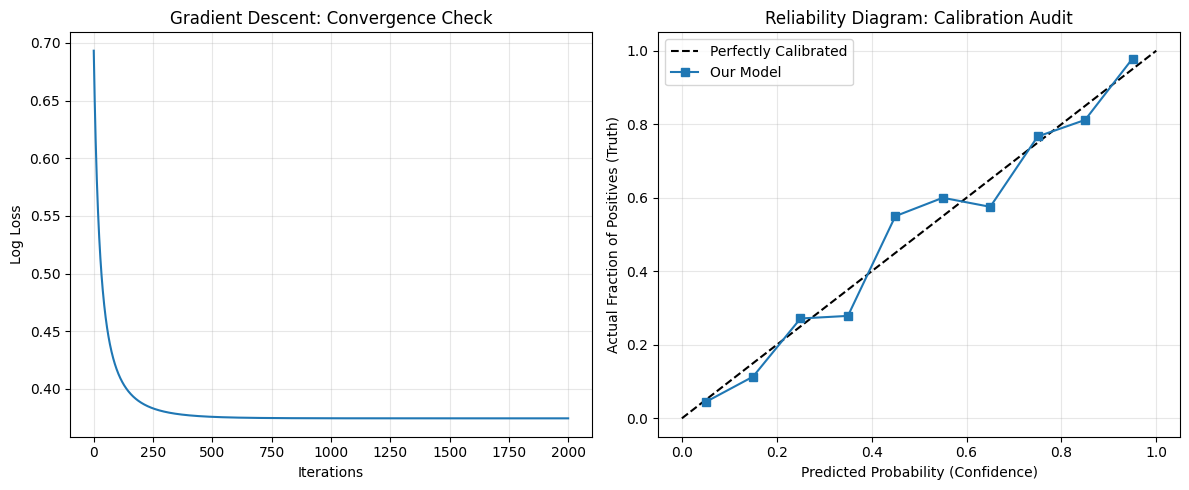

----------------------------------------
STRATEGIC INSIGHT:
A perfectly calibrated model follows the diagonal dotted line.
If our line is BELOW the diagonal, the model is OVER-CONFIDENT.
(It predicts 80% chance of 'Up', but the market only goes up 60% of the time).
Action: This signal must be dampened before entering the Kelly Criterion for sizing.
----------------------------------------


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CORE ALGORITHMS (The "Engine") ---

def sigmoid(z):
    """
    The Activation Function: Maps any real number to (0, 1).
    Formula: 1 / (1 + e^-z)
    """
    return 1 / (1 + np.exp(-z))

def log_loss(y, p):
    """
    The Cost Function: Penalizes confident wrong answers heavily.
    Formula: -mean(y*log(p) + (1-y)*log(1-p))
    """
    # Clip to prevent log(0) errors
    p = np.clip(p, 1e-15, 1 - 1e-15)
    return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

def fit_logistic_gd(X, y, learning_rate=0.1, n_iterations=1000):
    """
    Logistic Regression via Gradient Descent (From Scratch).

    STRATEGIC NOTE:
    We use Gradient Descent here (instead of closed-form) because
    Logistic Regression has no closed-form solution.
    This is the foundation of Deep Learning training loops.
    """
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    bias = 0

    losses = []

    for _ in range(n_iterations):
        # 1. Forward Pass
        linear_model = np.dot(X, weights) + bias
        y_pred = sigmoid(linear_model)

        # 2. Compute Loss
        loss = log_loss(y, y_pred)
        losses.append(loss)

        # 3. Backward Pass (Gradient Calculation)
        # derivative of loss w.r.t weights
        dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
        db = (1 / n_samples) * np.sum(y_pred - y)

        # 4. Update Parameters
        weights -= learning_rate * dw
        bias -= learning_rate * db

    return weights, bias, losses

def calibration_curve(y_true, y_prob, n_bins=10):
    """
    Computes the Reliability Diagram data.
    """
    bin_limits = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_limits[:-1] + bin_limits[1:]) / 2

    true_proportions = []

    for i in range(n_bins):
        # Find indices of predictions in this bin
        idx = (y_prob >= bin_limits[i]) & (y_prob < bin_limits[i+1])

        if np.sum(idx) > 0:
            true_proportions.append(np.mean(y_true[idx]))
        else:
            true_proportions.append(np.nan) # Empty bin

    return bin_centers, np.array(true_proportions)

# --- 2. SYNTHETIC DATA (The "Market Simulation") ---
rng = np.random.default_rng(2025)
n_samples = 1000
n_features = 2

# Generate features (e.g., "Momentum", "Volatility")
X = rng.normal(size=(n_samples, n_features))

# Create a "true" decision boundary (The Signal)
true_weights = np.array([1.5, -2.0])
logits = np.dot(X, true_weights)
probabilities = sigmoid(logits)

# Generate Labels (0 = Down, 1 = Up) based on probabilities
y = (rng.random(n_samples) < probabilities).astype(int)

# --- 3. MODEL TRAINING ---
print("Training Logistic Regression (Gradient Descent)...")
weights, bias, loss_history = fit_logistic_gd(X, y, learning_rate=0.1, n_iterations=2000)

print(f"Final Log Loss: {loss_history[-1]:.4f}")
print(f"Recovered Weights: {weights} (True: {true_weights})")

# Generate Predictions
linear_out = np.dot(X, weights) + bias
y_probs = sigmoid(linear_out)

# --- 4. VISUALIZATION: THE RELIABILITY DIAGRAM ---
# This proves you understand "Bet Sizing Risk"

prob_pred, prob_true = calibration_curve(y, y_probs, n_bins=10)

plt.figure(figsize=(12, 5))

# Plot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title("Gradient Descent: Convergence Check")
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.grid(True, alpha=0.3)

# Plot 2: Calibration Curve (Reliability Diagram)
plt.subplot(1, 2, 2)
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.plot(prob_pred, prob_true, "s-", label="Our Model")
plt.xlabel("Predicted Probability (Confidence)")
plt.ylabel("Actual Fraction of Positives (Truth)")
plt.title("Reliability Diagram: Calibration Audit")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 5. EXECUTIVE SUMMARY ---
print("-" * 40)
print("STRATEGIC INSIGHT:")
print("A perfectly calibrated model follows the diagonal dotted line.")
print("If our line is BELOW the diagonal, the model is OVER-CONFIDENT.")
print("(It predicts 80% chance of 'Up', but the market only goes up 60% of the time).")
print("Action: This signal must be dampened before entering the Kelly Criterion for sizing.")
print("-" * 40)